In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image
import shutil

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter
import warnings

print("Imoprted Complitely!")

Imoprted Complitely!


/tmp/ipykernel_34/95286717.py:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((desired_width, desired_height), Image.ANTIALIAS)


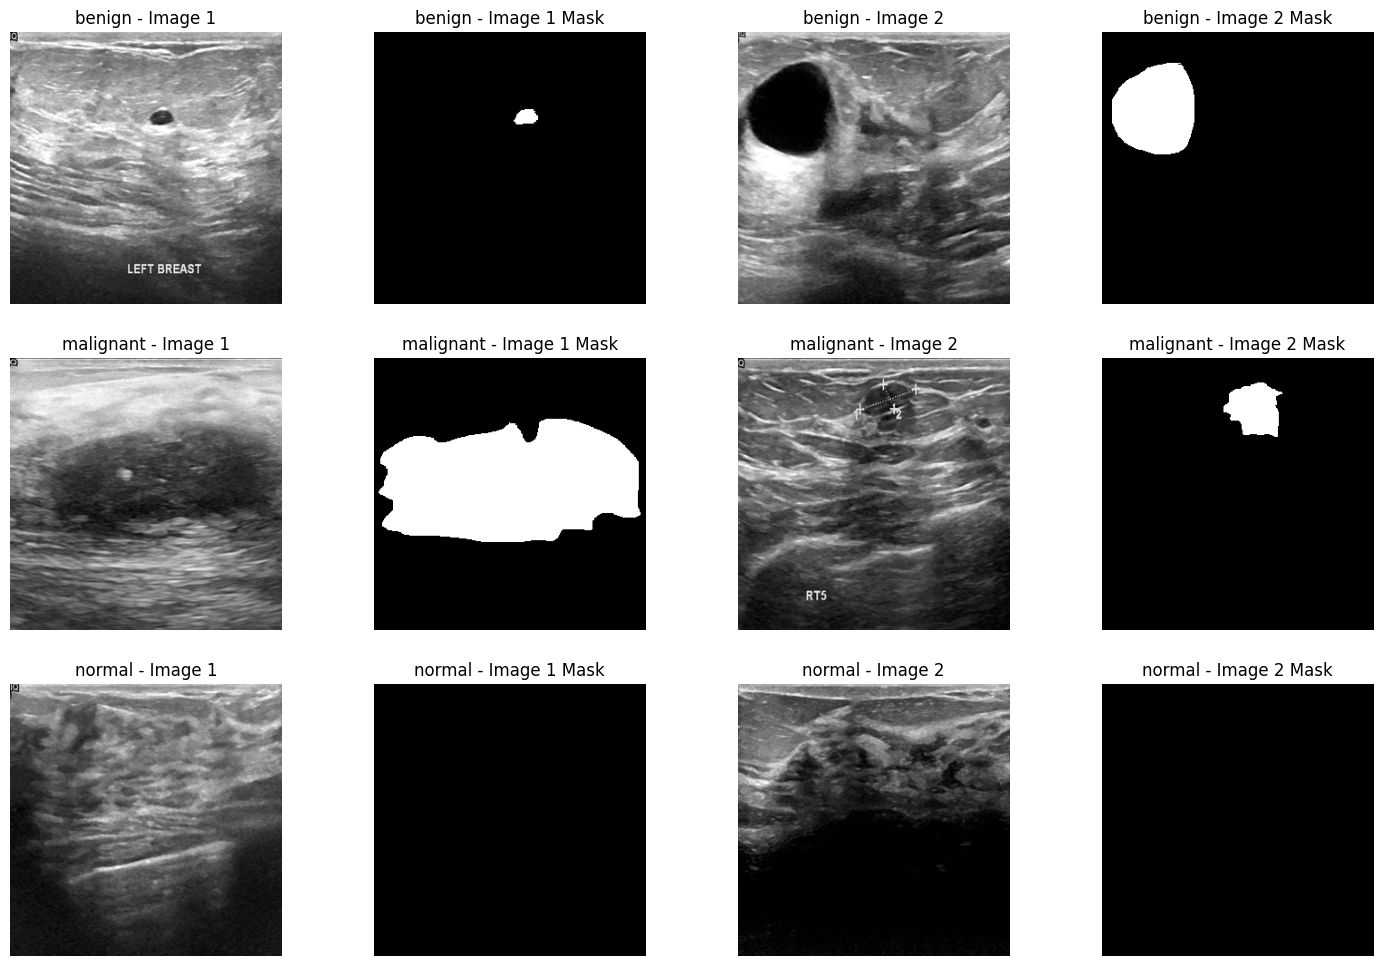

In [2]:
labels = ['benign', 'malignant', 'normal']
data_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

fig, axs = plt.subplots(3, 4, figsize=(18, 12))

desired_width = 300
desired_height = 300

for i, label in enumerate(labels):
    label_dir = os.path.join(data_dir, label)
    
    image_files = [file for file in os.listdir(label_dir) if file.endswith('.png')]
    
    image_files = sorted(image_files)
    
    for j in range(4):
        if j < len(image_files):
            image_path = os.path.join(label_dir, image_files[j])
            image = Image.open(image_path)
            image = image.resize((desired_width, desired_height), Image.ANTIALIAS)
            
            if j % 2 == 0:
                image_label = f'{label} - Image {j // 2 + 1}'
            else:
                image_label = f'{label} - Image {j // 2 + 1} Mask'
            
            axs[i, j].imshow(image)
            axs[i, j].set_title(image_label)
            axs[i, j].axis('off')

In [3]:
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
data_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

file_paths = []
labels = []

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or 
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/validation'
test_dir = '/kaggle/working/test'

for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))

Train benign: 315
Train malignant: 152
Train normal: 96
Validation benign: 56
Validation malignant: 27
Validation normal: 17
test benign: 66
test malignant: 31
test normal: 20


/tmp/ipykernel_34/3487001929.py:64: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((desired_width, desired_height), Image.ANTIALIAS)


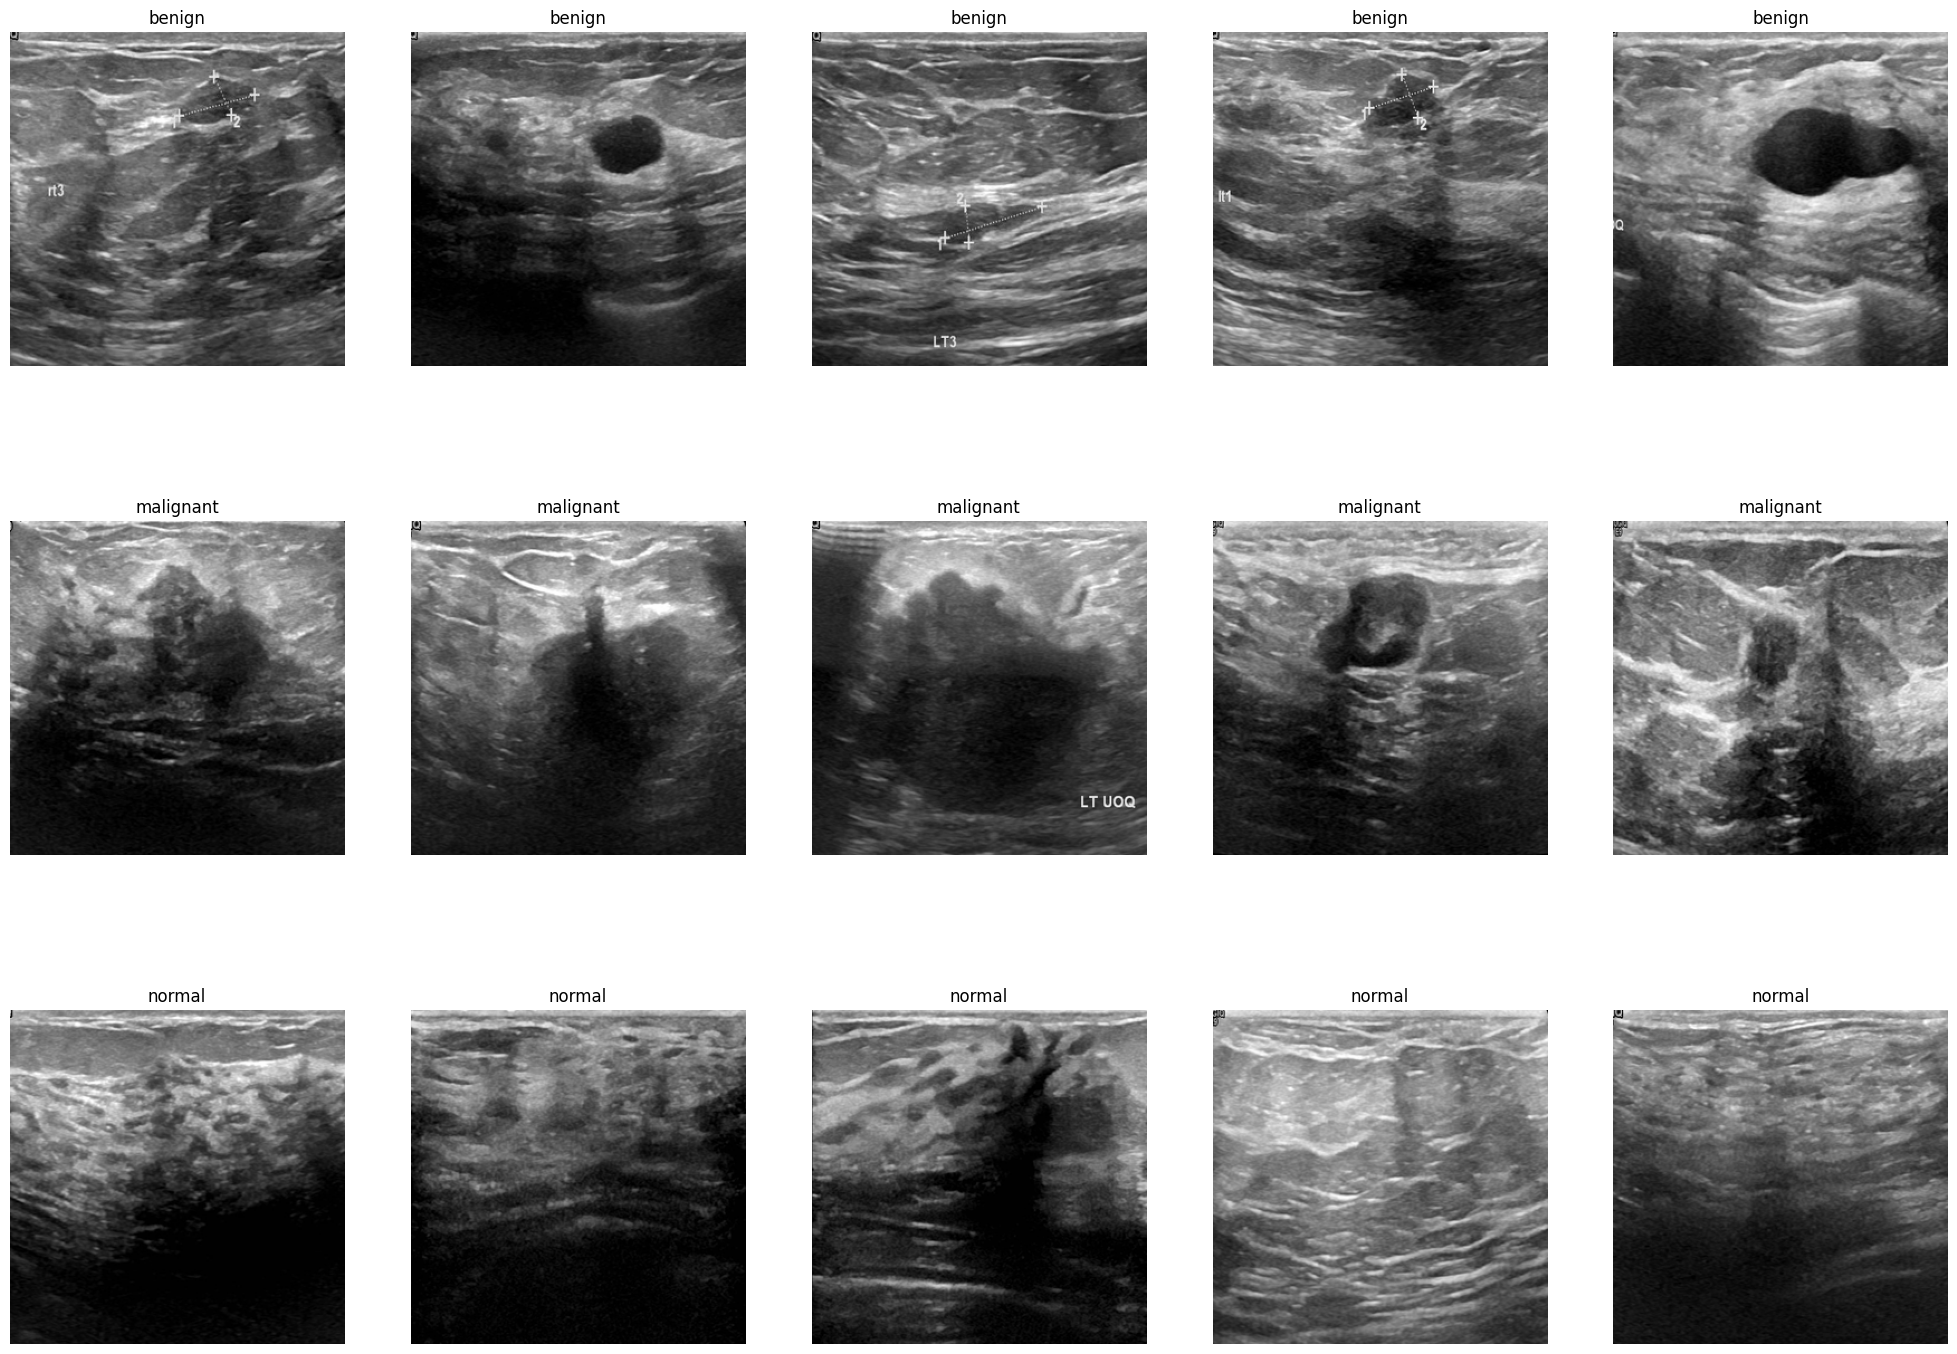

In [5]:
train_dir = '/kaggle/working/train'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Train {category}: {count}")

validation_dir = '/kaggle/working/validation'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(validation_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Validation {category}: {count}")

test_dir = '/kaggle/working/test'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"test {category}: {count}")


train_dir = '/kaggle/working/train'

labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(train_dir, label) for label in labels]

fig, axs = plt.subplots(3, 5, figsize=(25, 18))

desired_width = 300
desired_height = 300

for i, label_dir in enumerate(label_dirs):
    images = [image for image in os.listdir(label_dir) if not image.endswith('_mask.png')][:5]

    for j, image_filename in enumerate(images):
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)
        
        image = image.resize((desired_width, desired_height), Image.ANTIALIAS)
        
        axs[i, j].imshow(image)
        axs[i, j].set_title(labels[i])
        axs[i, j].axis('off')


data_dir='/kaggle/working/'

image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}

In [6]:
batch_size = 8

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'validation', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

class_names = image_datasets['train'].classes

print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

def train_model_with_early_stopping(model, lossFunction, optimizer, scheduler, dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    consecutive_epochs_without_improvement = 0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                if phase == 'train':
                    train_losses.append(loss.item())
                else:
                    val_losses.append(loss.item())

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'validation':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    consecutive_epochs_without_improvement = 0
                else:
                    consecutive_epochs_without_improvement += 1


                val_losses.append(epoch_loss)

        if consecutive_epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch} epochs")
            break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:.4f}'.format(best_loss))
   
    model.load_state_dict(best_model_wts)
    
    y_true = []
    y_pred = []

    model.eval()

    with torch.no_grad():
        for inputs, labels in dataloaders['validation']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    target_names = [str(class_names[i]) for i in range(len(class_names))]
    print(classification_report(y_true, y_pred, target_names=target_names))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix 1:")
    print(cm)

    return model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Dataset Sizes: {'train': 563, 'validation': 100, 'test': 117}
Class Labels: ['benign', 'malignant', 'normal']


In [7]:
from torchvision import models
# Load the pretrained model
MobileNet = models.mobilenet_v3_large(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 83.2MB/s]


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/29
----------
train Loss: 1.0360 Acc: 0.5080
validation Loss: 1.0291 Acc: 0.5300

Epoch 1/29
----------
train Loss: 0.9334 Acc: 0.5773
validation Loss: 0.9572 Acc: 0.6400

Epoch 2/29
----------
train Loss: 0.8957 Acc: 0.5915
validation Loss: 0.9051 Acc: 0.6300

Epoch 3/29
----------
train Loss: 0.8546 Acc: 0.6075
validation Loss: 0.8646 Acc: 0.6200

Epoch 4/29
----------
train Loss: 0.8092 Acc: 0.6199
validation Loss: 0.8199 Acc: 0.6400

Epoch 5/29
----------
train Loss: 0.7715 Acc: 0.6696
validation Loss: 0.7762 Acc: 0.7000

Epoch 6/29
----------
train Loss: 0.7273 Acc: 0.6821
validation Loss: 0.7326 Acc: 0.7000

Epoch 7/29
----------
train Loss: 0.6850 Acc: 0.7158
validation Loss: 0.6887 Acc: 0.7100

Epoch 8/29
----------
train Loss: 0.6449 Acc: 0.7265
validation Loss: 0.6528 Acc: 0.7300

Epoch 9/29
----------
train Loss: 0.6123 Acc: 0.7425
validation Loss: 0.6283 Acc: 0.7300

Epoch 10/29
----------
train Loss: 0.6153 Acc: 0.7353
validation Loss: 0.6124 Acc: 0.7300

Epoch 11/

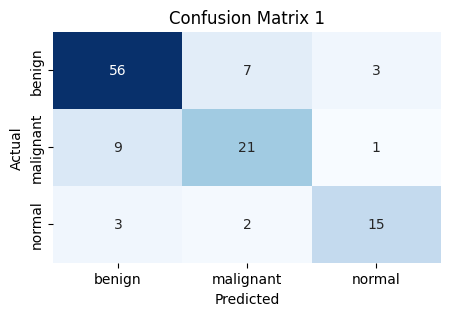

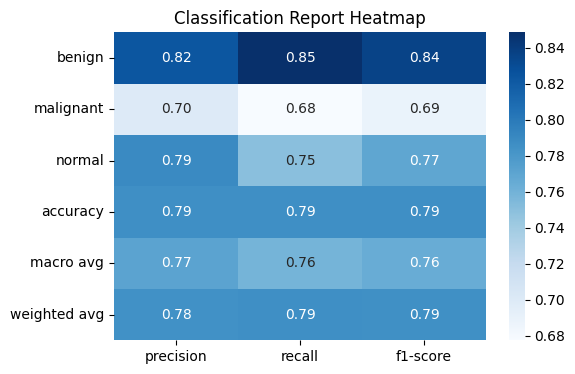

Simplified Classification Report:
             benign  malignant    normal  accuracy  macro avg  weighted avg
precision  0.823529   0.700000  0.789474  0.786325   0.771001      0.784978
recall     0.848485   0.677419  0.750000  0.786325   0.758635      0.786325
f1-score   0.835821   0.688525  0.769231  0.786325   0.764525      0.785411


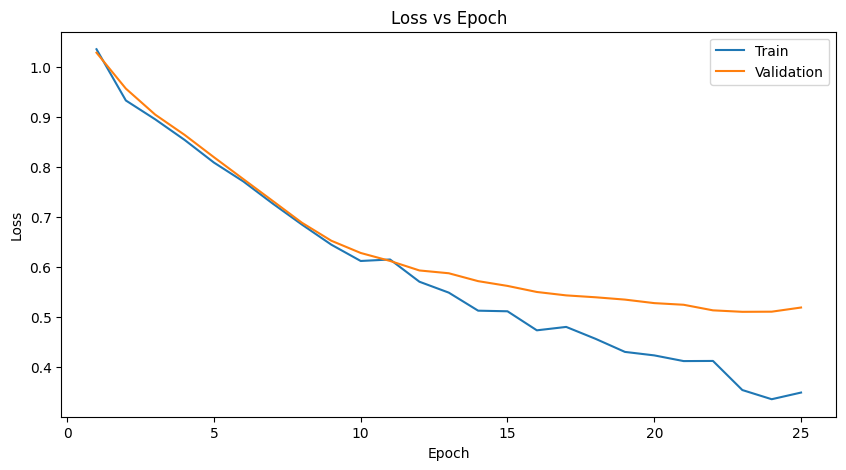

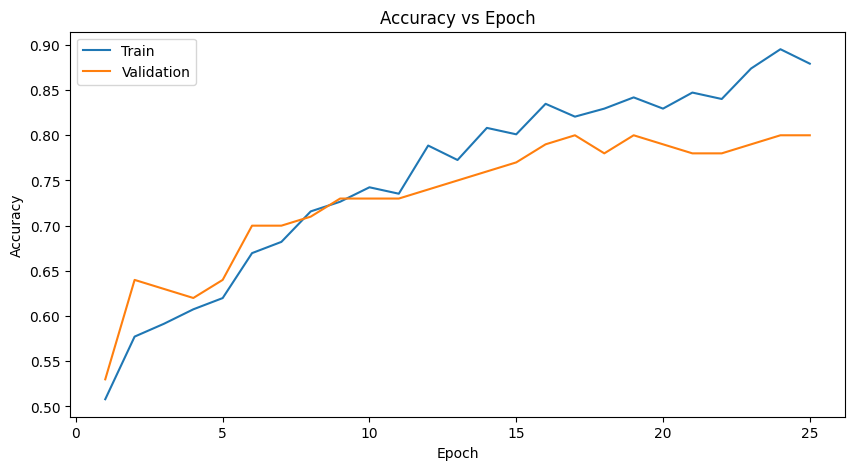

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained model
MobileNet = models.mobilenet_v3_large(pretrained=True)

# Set requires_grad = True for all parameters
for param in MobileNet.parameters():
    param.requires_grad = True

# Get the number of input features of the last layer
in_features = MobileNet.classifier[3].in_features

# Replace the last layer with a new one with output features equal to the number of classes
MobileNet.classifier[3] = nn.Linear(in_features, len(class_names))

# Move the model to the device
MobileNet_fineTuning = MobileNet.to(device)

# Define the optimizer
optimizer = optim.Adam(MobileNet_fineTuning.parameters(), lr=0.00001)

# Define the learning rate scheduler
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define the loss function
Loss_Function = nn.CrossEntropyLoss()

# Train the model with early stopping
model_fineTuning, train_losses, val_losses, train_accs, val_accs = train_model_with_early_stopping(
    MobileNet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate, 
    dataloaders, dataset_sizes, class_names, device, num_epochs=30, patience=2)

# Save the model
torch.save(model_fineTuning, "/kaggle/working/MobileNet_approach1.keras")

label_names = [str(class_names[i]) for i in range(len(class_names))]

y_true = []
y_pred = []

model_fineTuning.eval()

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_fineTuning(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

confusion_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 1')
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()

print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])

# Convert tensors to numpy arrays
train_accs_np = [acc.cpu().numpy() for acc in train_accs]
val_accs_np = [acc.cpu().numpy() for acc in val_accs]

# Plot the accuracy and loss graphs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accs_np) + 1), train_accs_np, label='Train')
plt.plot(range(1, len(val_accs_np) + 1), val_accs_np, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

(3, 3)


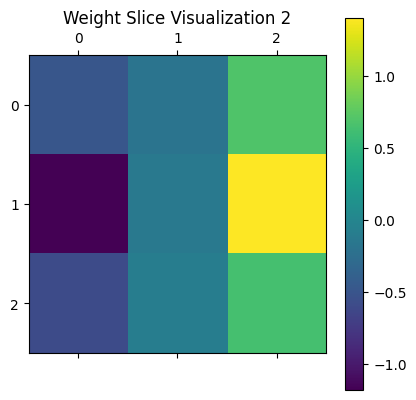

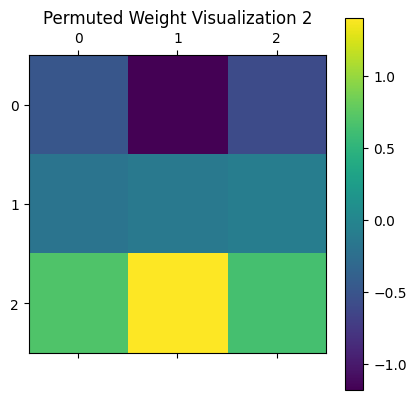

Slice Matrix 2=  [[-0.48837626 -0.19340816  0.69484603]
 [-1.1833038  -0.13818571  1.4017408 ]
 [-0.59285235 -0.08880264  0.63528454]]
permuted Matrix 2=  [[-0.48837626 -1.1833038  -0.59285235]
 [-0.19340816 -0.13818571 -0.08880264]
 [ 0.69484603  1.4017408   0.63528454]]


In [16]:
conv = next(m for m in model_fineTuning.modules() if isinstance(m, torch.nn.Conv2d))
weights = conv.weight

slice = weights[0,0,:,:]  

slice = slice.detach()

slice = slice.cpu()

slice_np = slice.numpy()  

print(slice_np.shape)

plt.matshow(slice_np)
plt.title("Weight Slice Visualization 2")
plt.colorbar()
plt.show()

permuted = np.transpose(slice_np, (1,0))

plt.matshow(permuted)
plt.title("Permuted Weight Visualization 2")  
plt.colorbar()
plt.show()

print("Slice Matrix 2= ",slice_np)


print("permuted Matrix 2= ",permuted)

# **Approach 2**

In [17]:
# Set the path to the Kaggle working directory
working_dir = '/kaggle/working'

# Delete all files and subdirectories in the working directory
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)

# Confirm that the directory is empty
print("Kaggle working directory has been cleared.")



warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ResourceWarning)

input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'

output_dir = '/kaggle/working/OverlayedImages'

labels = ['benign', 'malignant', 'normal']
for label in labels:
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)

def overlay_and_save(image_path, mask_path, output_path):
    try:
        if os.path.exists(image_path) and os.path.exists(mask_path):
            image = Image.open(image_path)
            mask = Image.open(mask_path)

            if image.mode != mask.mode:
                mask = mask.convert(image.mode)

            if image.size != mask.size:
                image = image.resize(mask.size)

            overlayed = Image.blend(image, mask, alpha=0.5)

            label = os.path.basename(os.path.dirname(image_path))
            output_path = os.path.join(output_dir, label, os.path.basename(image_path))
            overlayed.save(output_path)
        else:
            pass
    except Exception as e:
        print(f"An error occurred for: {image_path} or {mask_path}. Error: {str(e)}")

for label in labels:
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        for image_filename in os.listdir(label_dir):
            if image_filename.endswith('.png'):
                image_path = os.path.join(label_dir, image_filename)
                mask_filename = image_filename.replace('.png', '_mask.png')
                mask_path = os.path.join(label_dir, mask_filename)
                overlay_and_save(image_path, mask_path, output_dir)

print("Overlayed images have been saved to /kaggle/working/OverlayedImages directory.")

Kaggle working directory has been cleared.
Overlayed images have been saved to /kaggle/working/OverlayedImages directory.


In [18]:
def count_files_in_directory(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
output_dir = '/kaggle/working/OverlayedImages'

input_counts = {}
output_counts = {}

for label in os.listdir(input_dir):
    label_dir = os.path.join(input_dir, label)
    if os.path.isdir(label_dir):
        input_counts[label] = count_files_in_directory(label_dir)

for label in os.listdir(output_dir):
    label_dir = os.path.join(output_dir, label)
    if os.path.isdir(label_dir):
        output_counts[label] = count_files_in_directory(label_dir)

print("File Counts Before Overlay-includes masks:")
for label, count in input_counts.items():
    print(f"{label}: {count} files")

print("\nFile Counts After Overlay:")
for label, count in output_counts.items():
    print(f"{label}: {count} files")


File Counts Before Overlay-includes masks:
benign: 891 files
normal: 266 files
malignant: 421 files

File Counts After Overlay:
malignant: 210 files
normal: 133 files
benign: 437 files


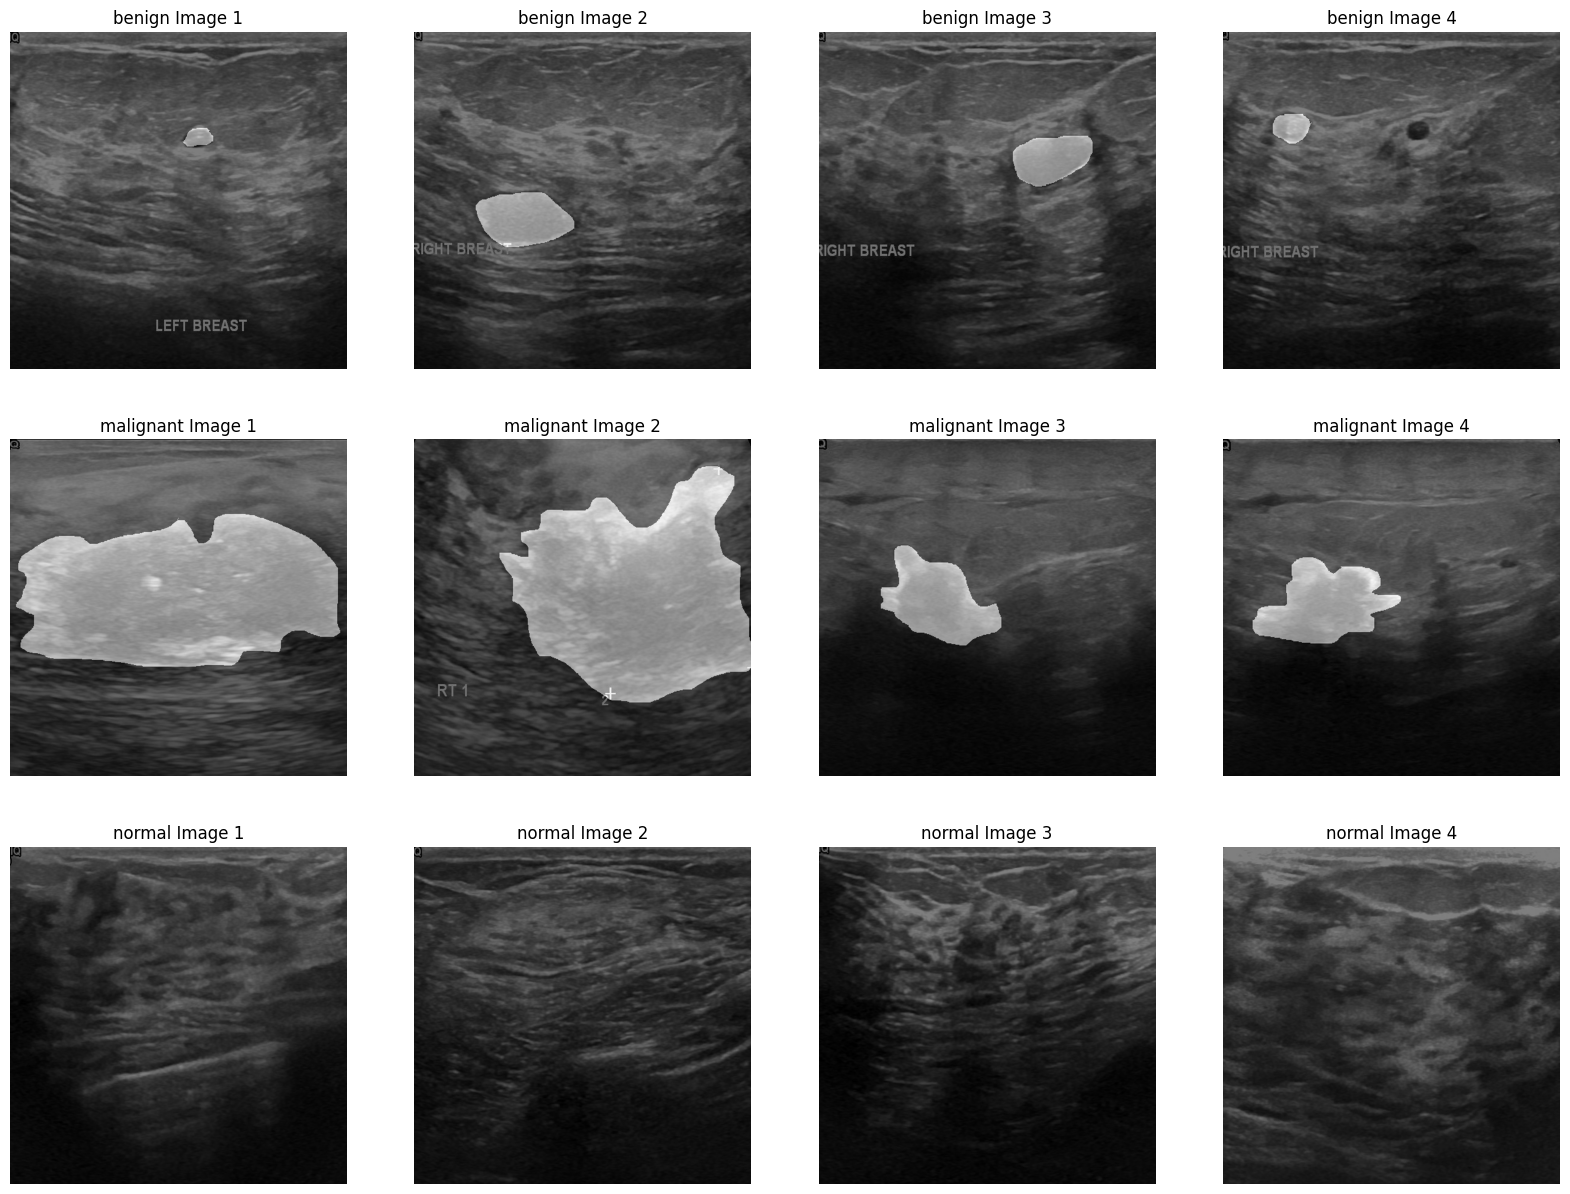

In [19]:
overlayed_dir = '/kaggle/working/OverlayedImages'

labels = ['benign', 'malignant', 'normal']
label_dirs = [os.path.join(overlayed_dir, label) for label in labels]

fig, axs = plt.subplots(3, 4, figsize=(20, 15))

desired_width = 800
desired_height = 800

for i, label_dir in enumerate(label_dirs):
    images = [image for image in os.listdir(label_dir) if image.endswith('.png')]
    images.sort(key=lambda x: int(x.split('(')[1].split(')')[0]))

    for j, image_filename in enumerate(images[:4]):
        image_path = os.path.join(label_dir, image_filename)
        image = Image.open(image_path)

        image = image.resize((desired_width, desired_height), Image.ANTIALIAS)

        axs[i, j].imshow(image)
        axs[i, j].set_title(f'{labels[i]} Image {j + 1}')
        axs[i, j].axis('off')

plt.show()


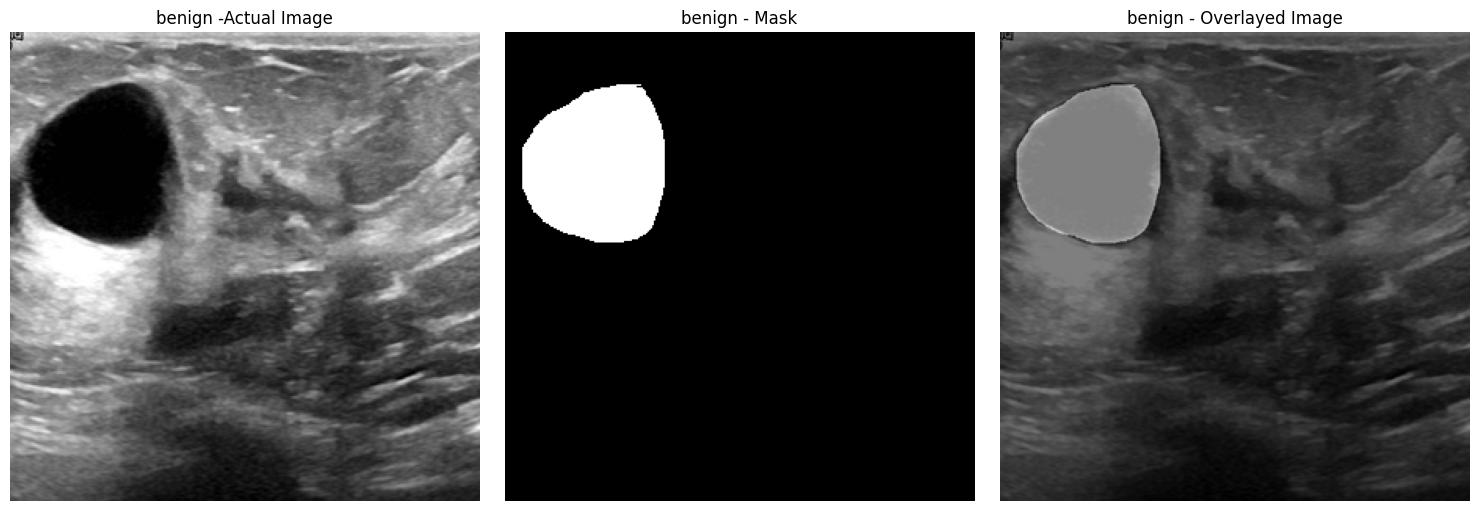

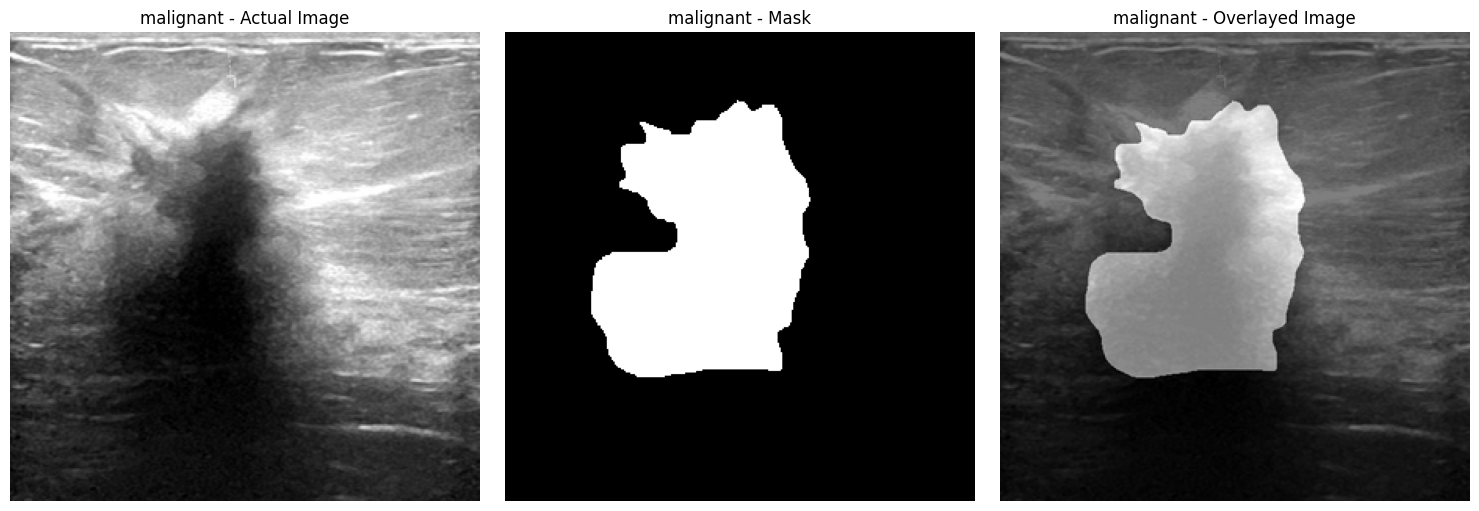

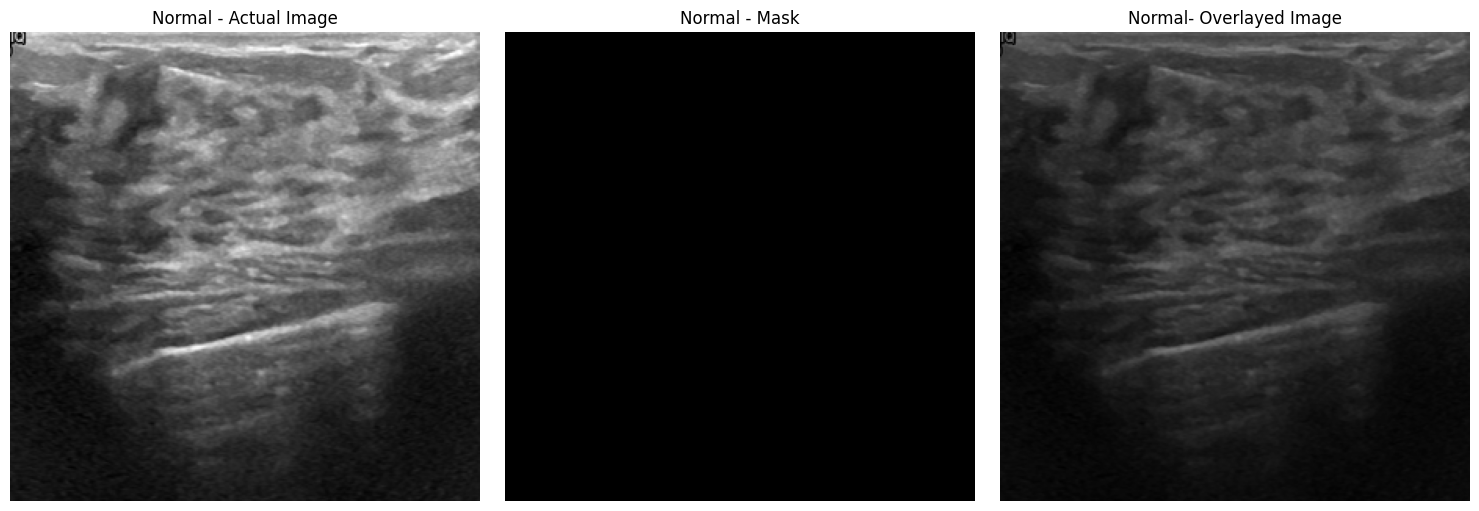

In [20]:
input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
overlayed_dir = '/kaggle/working/OverlayedImages/benign'

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

desired_width = 300
desired_height = 300

image_filename = 'benign (10).png'

actual_image_path = os.path.join(input_dir, 'benign', image_filename)
mask_image_path = os.path.join(input_dir, 'benign', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

axs[0].imshow(actual_image)
axs[0].set_title('benign -Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('benign - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('benign - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()


input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
overlayed_dir = '/kaggle/working/OverlayedImages/malignant'

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

desired_width = 300
desired_height = 300

image_filename = 'malignant (103).png'

actual_image_path = os.path.join(input_dir, 'malignant', image_filename)
mask_image_path = os.path.join(input_dir, 'malignant', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

axs[0].imshow(actual_image)
axs[0].set_title('malignant - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('malignant - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('malignant - Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()

input_dir = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
overlayed_dir = '/kaggle/working/OverlayedImages/normal'

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

desired_width = 300
desired_height = 300

image_filename = 'normal (1).png'

actual_image_path = os.path.join(input_dir, 'normal', image_filename)
mask_image_path = os.path.join(input_dir, 'normal', image_filename.replace(".png", "_mask.png"))
overlayed_image_path = os.path.join(overlayed_dir, image_filename)

actual_image = Image.open(actual_image_path)
mask_image = Image.open(mask_image_path)
overlayed_image = Image.open(overlayed_image_path)

actual_image = actual_image.resize((desired_width, desired_height), Image.ANTIALIAS)
mask_image = mask_image.resize((desired_width, desired_height), Image.ANTIALIAS)
overlayed_image = overlayed_image.resize((desired_width, desired_height), Image.ANTIALIAS)

axs[0].imshow(actual_image)
axs[0].set_title('Normal - Actual Image')
axs[0].axis('off')

axs[1].imshow(mask_image, cmap='gray')
axs[1].set_title('Normal - Mask')
axs[1].axis('off')

axs[2].imshow(overlayed_image)
axs[2].set_title('Normal- Overlayed Image')
axs[2].axis('off')

plt.tight_layout()
plt.show()


In [21]:
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/working/OverlayedImages'

file_paths = []
labels = []

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or 
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)


In [22]:
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

train_data, test_data = train_test_split(data, test_size=0.15, random_state=42, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data['Label'])

train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/validation'
test_dir = '/kaggle/working/test'

for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

for _, row in train_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(train_dir, label))

for _, row in val_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(val_dir, label))

for _, row in test_data.iterrows():
    image_path = row['Image_Path']
    label = row['Label']
    shutil.copy(image_path, os.path.join(test_dir, label))


file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(train_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Train {category}: {count}")

validation_dir = '/kaggle/working/validation'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(validation_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"Validation {category}: {count}")


test_dir = '/kaggle/working/test'

subdirectories = ['benign', 'malignant', 'normal']

file_counts = {}

for subdirectory in subdirectories:
    subdirectory_path = os.path.join(test_dir, subdirectory)
    if os.path.exists(subdirectory_path):
        file_count = len(os.listdir(subdirectory_path))
        file_counts[subdirectory] = file_count

for category, count in file_counts.items():
    print(f"test {category}: {count}")

data_dir='/kaggle/working/'

image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}


Train benign: 315
Train malignant: 152
Train normal: 96
Validation benign: 56
Validation malignant: 27
Validation normal: 17
test benign: 66
test malignant: 31
test normal: 20


In [23]:
batch_size = 8

dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
               for x in ['train', 'validation', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

class_names = image_datasets['train'].classes

print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

train_dir = '/kaggle/working/train'

subdirectories = ['benign', 'malignant', 'normal']


Dataset Sizes: {'train': 563, 'validation': 100, 'test': 117}
Class Labels: ['benign', 'malignant', 'normal']


Epoch 0/49
----------
train Loss: 0.9866 Acc: 0.5240
validation Loss: 0.9054 Acc: 0.7300

Epoch 1/49
----------
train Loss: 0.8052 Acc: 0.6661
validation Loss: 0.7505 Acc: 0.8400

Epoch 2/49
----------
train Loss: 0.6777 Acc: 0.7318
validation Loss: 0.6114 Acc: 0.8500

Epoch 3/49
----------
train Loss: 0.5699 Acc: 0.8206
validation Loss: 0.4951 Acc: 0.8800

Epoch 4/49
----------
train Loss: 0.4511 Acc: 0.8739
validation Loss: 0.4044 Acc: 0.9200

Epoch 5/49
----------
train Loss: 0.3964 Acc: 0.8934
validation Loss: 0.3349 Acc: 0.9600

Epoch 6/49
----------
train Loss: 0.3476 Acc: 0.9094
validation Loss: 0.2739 Acc: 0.9600

Epoch 7/49
----------
train Loss: 0.3066 Acc: 0.9130
validation Loss: 0.2255 Acc: 0.9600

Epoch 8/49
----------
train Loss: 0.2431 Acc: 0.9307
validation Loss: 0.1875 Acc: 0.9600

Epoch 9/49
----------
train Loss: 0.2504 Acc: 0.9236
validation Loss: 0.1568 Acc: 0.9600

Epoch 10/49
----------
train Loss: 0.2131 Acc: 0.9361
validation Loss: 0.1387 Acc: 0.9600

Epoch 11/

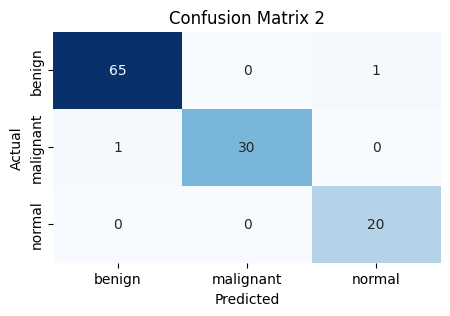

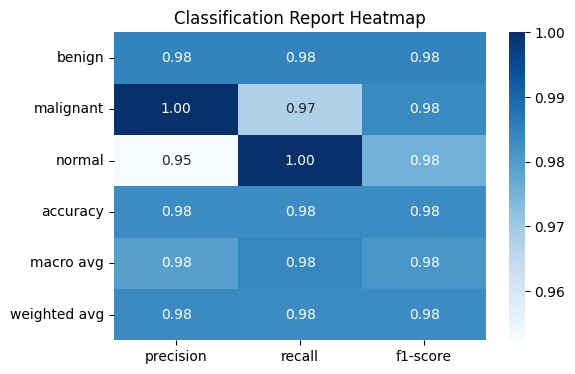

Simplified Classification Report:
             benign  malignant    normal  accuracy  macro avg  weighted avg
precision  0.984848   1.000000  0.952381  0.982906   0.979076      0.983313
recall     0.984848   0.967742  1.000000  0.982906   0.984197      0.982906
f1-score   0.984848   0.983607  0.975610  0.982906   0.981355      0.982940


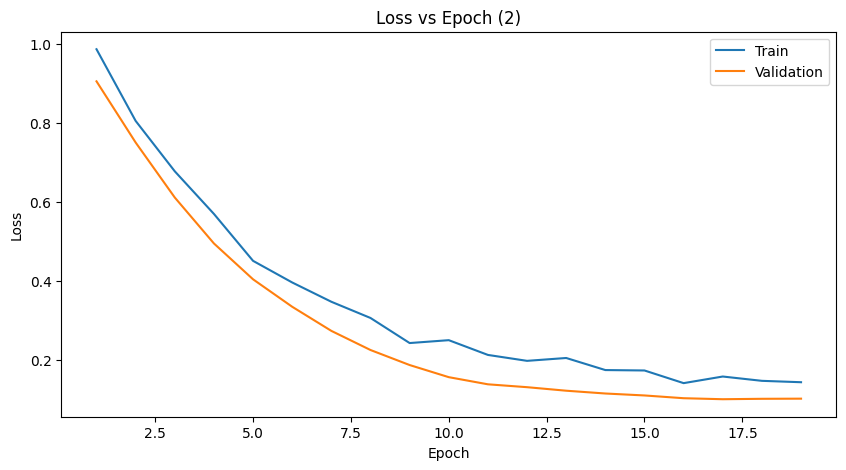

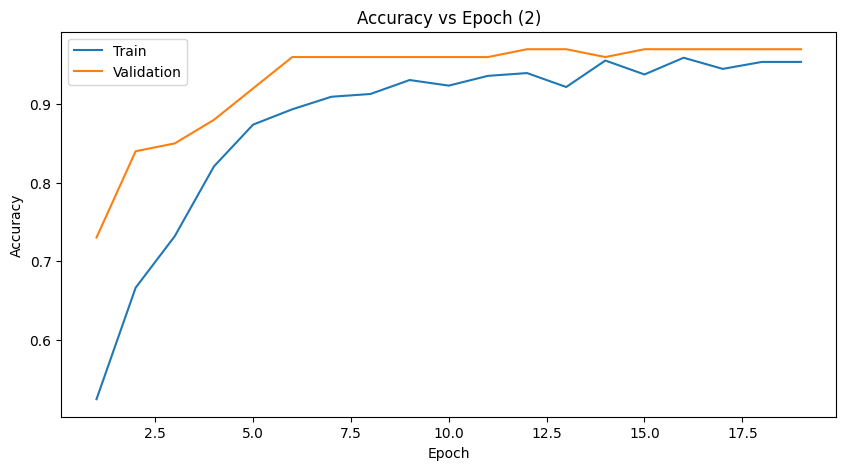

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Load the pretrained model
MobileNet = models.mobilenet_v3_large(pretrained=True)

# Set requires_grad = True for all parameters
for param in MobileNet.parameters():
    param.requires_grad = True

# Get the number of input features of the last layer
in_features = MobileNet.classifier[3].in_features

# Replace the last layer with a new one with output features equal to the number of classes
MobileNet.classifier[3] = nn.Linear(in_features, len(class_names))

# Move the model to the device
MobileNet_fineTuning = MobileNet.to(device)

# Define the optimizer
optimizer = optim.Adam(MobileNet_fineTuning.parameters(), lr=0.00001)

# Define the learning rate scheduler
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define the loss function
Loss_Function = nn.CrossEntropyLoss()

# Train the model with early stopping
model_fineTuning2, train_losses2, val_losses2, train_accs2, val_accs2 = train_model_with_early_stopping(
    MobileNet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate, 
    dataloaders, dataset_sizes, class_names, device, num_epochs=50, patience=2)

# Save the model
torch.save(model_fineTuning2, "/kaggle/working/MobileNet_approach2.keras")

label_names = [str(class_names[i]) for i in range(len(class_names))]

y_true = []
y_pred = []

model_fineTuning2.eval()

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_fineTuning2(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

classification_rep = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

confusion_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 2')
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(classification_rep).iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()

print("Simplified Classification Report:")
print(pd.DataFrame(classification_rep).iloc[:-1, :])

# Convert tensors to numpy arrays
train_accs_np2 = [acc.cpu().numpy() for acc in train_accs2]
val_accs_np2 = [acc.cpu().numpy() for acc in val_accs2]

# Plot the accuracy and loss graphs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses2) + 1), train_losses2, label='Train')
plt.plot(range(1, len(val_losses2) + 1), val_losses2, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch (2)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accs_np2) + 1), train_accs_np2, label='Train')
plt.plot(range(1, len(val_accs_np2) + 1), val_accs_np2, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch (2)')
plt.legend()
plt.show()

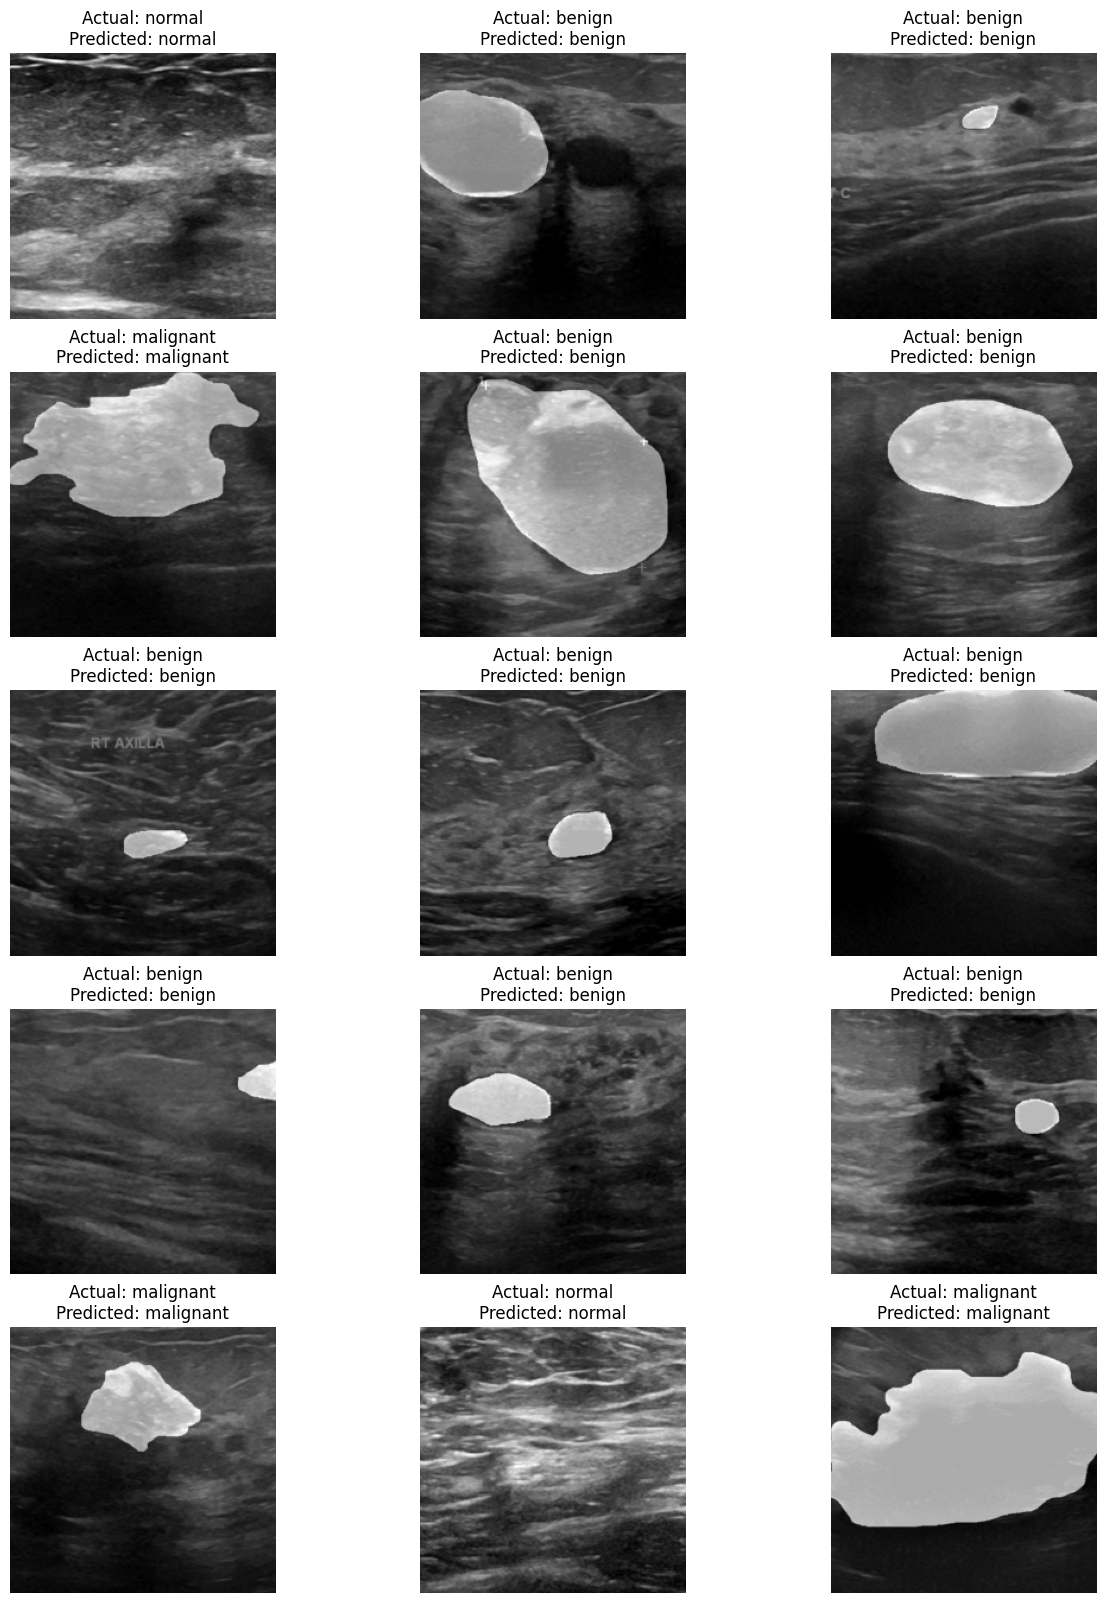

In [30]:
num_images_to_display = 15

test_dataloader = DataLoader(image_datasets['test'], batch_size=num_images_to_display, shuffle=True, num_workers=4)

inputs, labels = next(iter(test_dataloader))

inputs = inputs.to(device)

grayscale_images = inputs.cpu().numpy().mean(axis=1)

with torch.no_grad():
    model_fineTuning2.eval()
    outputs = model_fineTuning2(inputs)
    _, preds = torch.max(outputs, 1)

plt.figure(figsize=(15, 20))
for i in range(num_images_to_display):
    ax = plt.subplot(5, 3, i + 1)
    ax.axis('off')
    ax.set_title(f'Actual: {class_names[labels[i]]}\nPredicted: {class_names[preds[i]]}')
    plt.imshow(grayscale_images[i], cmap='gray')

plt.show()

(3, 3)


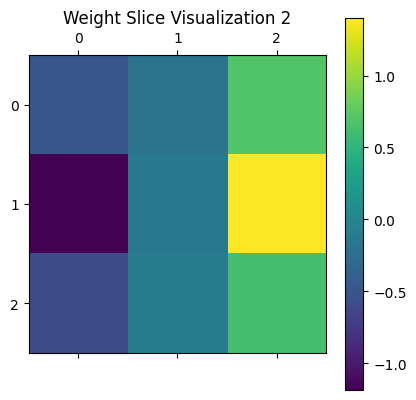

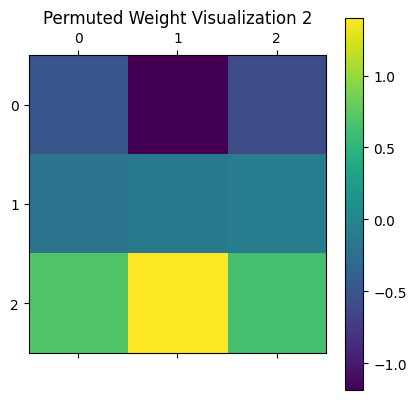

Slice Matrix 2=  [[-0.49057117 -0.19555391  0.69278544]
 [-1.1853867  -0.1403174   1.3996099 ]
 [-0.59488726 -0.09091367  0.6331963 ]]
permuted Matrix 2=  [[-0.49057117 -1.1853867  -0.59488726]
 [-0.19555391 -0.1403174  -0.09091367]
 [ 0.69278544  1.3996099   0.6331963 ]]


In [31]:
conv = next(m for m in model_fineTuning2.modules() if isinstance(m, torch.nn.Conv2d))
weights = conv.weight

slice = weights[0,0,:,:]  

slice = slice.detach()

slice = slice.cpu()

slice_np = slice.numpy()  

print(slice_np.shape)

plt.matshow(slice_np)
plt.title("Weight Slice Visualization 2")
plt.colorbar()
plt.show()

permuted = np.transpose(slice_np, (1,0))

plt.matshow(permuted)
plt.title("Permuted Weight Visualization 2")  
plt.colorbar()
plt.show()

print("Slice Matrix 2= ",slice_np)


print("permuted Matrix 2= ",permuted)

In [33]:
torch.save(model_fineTuning,"/kaggle/working/MobileNet_approach1.keras")
torch.save(model_fineTuning2,"/kaggle/working/MobileNet_approach2.keras")
print(f'models saved in {working_dir} successfully!')

models saved in /kaggle/working successfully!


In [44]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Define the directory containing the dataset
data_dir = '/kaggle/working/OverlayedImages'

# Define data transformations including resizing
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),
    # Add more transformations as needed
])

# Load the dataset using ImageFolder and apply transformations
dataset = ImageFolder(root=data_dir, transform=data_transforms)

In [45]:
print("Dataset size:", len(dataset))
print("Classes:", dataset.classes)

Dataset size: 780
Classes: ['benign', 'malignant', 'normal']


# Cross Validation

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Function to train the model with early stopping
def train_model_with_early_stopping(model, criterion, optimizer, scheduler, dataloaders, class_names, device, num_epochs=25, patience=3, dataset_sizes=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping_counter = 0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val':
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

# Define the number of splits for cross-validation
num_splits = 5
# Initialize lists to store metrics across folds
fold_train_losses = []
fold_val_losses = []
fold_train_accs = []
fold_val_accs = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(dataset)):  # Using 'dataset' instead of 'data'
    print(f"Fold {fold + 1}/{num_splits}")
    print("-" * 10)
    
    # Split data into training and validation sets for this fold
    train_data = torch.utils.data.Subset(dataset, train_index)
    val_data = torch.utils.data.Subset(dataset, val_index)
    
    # Create dataloaders for this fold
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    # Initialize MobileNet model
    MobileNet = models.mobilenet_v3_large(pretrained=True)
    for param in MobileNet.parameters():
        param.requires_grad = True
    in_features = MobileNet.classifier[3].in_features
    MobileNet.classifier[3] = nn.Linear(in_features, len(class_names))
    MobileNet_fineTuning = MobileNet.to(device)
    
    # Define optimizer, scheduler, and loss function
    optimizer = optim.Adam(MobileNet_fineTuning.parameters(), lr=0.00001)
    Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    Loss_Function = nn.CrossEntropyLoss()
    
    # Calculate the sizes of the train and validation datasets
    dataset_sizes = {'train': len(train_data), 'val': len(val_data)}

    # Train the model with early stopping
    model, train_losses, val_losses, train_accs, val_accs = train_model_with_early_stopping(
        MobileNet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate, 
        {'train': train_loader, 'val': val_loader}, class_names, device, num_epochs=50, patience=3, dataset_sizes=dataset_sizes)
    
    # Save metrics for this fold
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accs.append(train_accs)
    fold_val_accs.append(val_accs)
    
max_length_acc = max(len(accs) for accs in fold_val_accs)
padded_val_accs = [np.pad(accs.cpu().numpy(), (0, max_length_acc - len(accs)), mode='constant') for accs in fold_val_accs]

max_length = max(len(losses) for losses in fold_val_losses)
padded_val_losses = [np.pad(losses, (0, max_length - len(losses)), mode='constant') for losses in fold_val_losses]

# Compute average metrics across folds
avg_train_losses = np.mean(np.array(fold_train_losses), axis=0)
avg_val_losses = np.mean(np.array(padded_val_losses), axis=0)
avg_train_accs = np.mean(np.array(fold_train_accs), axis=0)
avg_val_accs = np.mean(np.array(padded_val_accs), axis=0)

# Plot the average accuracy and loss graphs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(avg_train_losses) + 1), avg_train_losses, label='Train')
plt.plot(range(1, len(avg_val_losses) + 1), avg_val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss vs Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(avg_train_accs) + 1), avg_train_accs, label='Train')
plt.plot(range(1, len(avg_val_accs) + 1), avg_val_accs, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy vs Epoch')
plt.legend()
plt.show()

Fold 1/5
----------
Epoch 0/49
----------
train Loss: 0.9794 Acc: 0.5353
val Loss: 1.0038 Acc: 0.5962
Epoch 1/49
----------
train Loss: 0.7606 Acc: 0.7003
val Loss: 0.9647 Acc: 0.5513
Epoch 2/49
----------
train Loss: 0.5813 Acc: 0.8029
val Loss: 1.0597 Acc: 0.6731
Epoch 3/49
----------
train Loss: 0.4439 Acc: 0.8958
val Loss: 1.2382 Acc: 0.6538
Epoch 4/49
----------
train Loss: 0.3539 Acc: 0.9311
val Loss: 1.3473 Acc: 0.7372
Epoch 5/49
----------
train Loss: 0.2965 Acc: 0.9183
val Loss: 1.4052 Acc: 0.7564
Epoch 6/49
----------
train Loss: 0.2612 Acc: 0.9279
val Loss: 0.8236 Acc: 0.8077
Epoch 7/49
----------
train Loss: 0.2066 Acc: 0.9503
val Loss: 0.4737 Acc: 0.8269
Epoch 8/49
----------
train Loss: 0.1884 Acc: 0.9615
val Loss: 0.3905 Acc: 0.8590
Epoch 9/49
----------
train Loss: 0.2124 Acc: 0.9439
val Loss: 0.2776 Acc: 0.9295
Epoch 10/49
----------
train Loss: 0.1982 Acc: 0.9567
val Loss: 0.2078 Acc: 0.9487
Epoch 11/49
----------
train Loss: 0.1883 Acc: 0.9583
val Loss: 0.1682 Acc: 0

AttributeError: 'list' object has no attribute 'cpu'

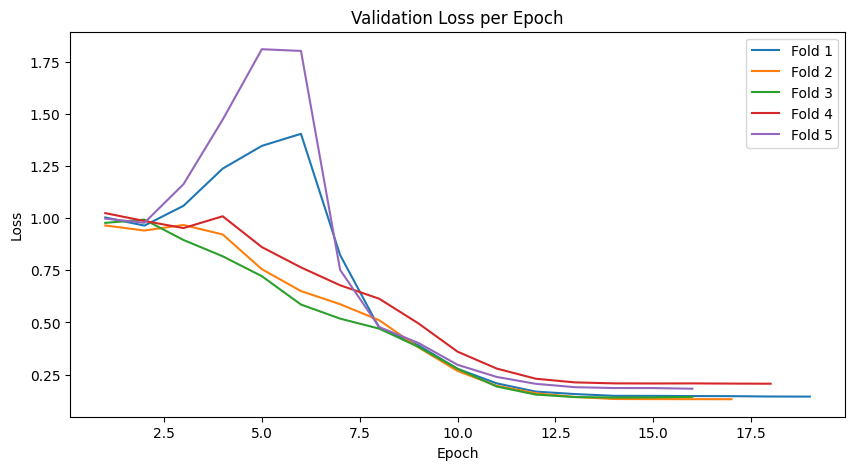

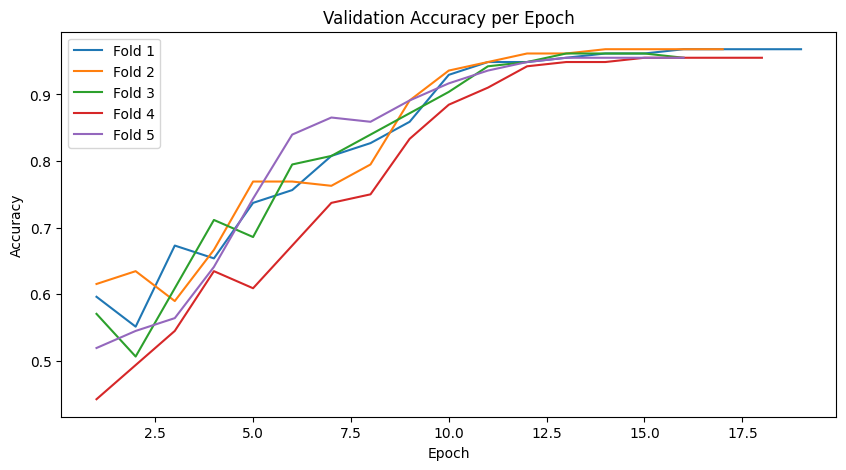

In [54]:
import matplotlib.pyplot as plt

# Plot the average loss graph
plt.figure(figsize=(10, 5))
for i, losses in enumerate(fold_val_losses):
    plt.plot(range(1, len(losses) + 1), losses, label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()
plt.show()

# Plot the average accuracy graph
plt.figure(figsize=(10, 5))
for i, accs in enumerate(fold_val_accs):
    accs_cpu = [acc.cpu().numpy() for acc in accs]
    plt.plot(range(1, len(accs_cpu) + 1), accs_cpu, label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.show()

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Function to train the model with early stopping
def train_model_with_early_stopping(model, criterion, optimizer, scheduler, dataloaders, class_names, device, num_epochs=25, patience=3, dataset_sizes=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping_counter = 0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val':
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

# Define the number of splits for cross-validation
num_splits = 5
# Initialize lists to store metrics across folds
fold_train_losses = []
fold_val_losses = []
fold_train_accs = []
fold_val_accs = []

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(dataset)):  # Using 'dataset' instead of 'data'
    print(f"Fold {fold + 1}/{num_splits}")
    print("-" * 10)
    
    # Split data into training and validation sets for this fold
    train_data = torch.utils.data.Subset(dataset, train_index)
    val_data = torch.utils.data.Subset(dataset, val_index)
    
    # Create dataloaders for this fold
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    # Initialize MobileNet model
    MobileNet = models.mobilenet_v3_large(pretrained=True)
    for param in MobileNet.parameters():
        param.requires_grad = True
    in_features = MobileNet.classifier[3].in_features
    MobileNet.classifier[3] = nn.Linear(in_features, len(class_names))
    MobileNet_fineTuning = MobileNet.to(device)
    
    # Define optimizer, scheduler, and loss function
    optimizer = optim.Adam(MobileNet_fineTuning.parameters(), lr=0.00001)
    Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    Loss_Function = nn.CrossEntropyLoss()
    
    # Calculate the sizes of the train and validation datasets
    dataset_sizes = {'train': len(train_data), 'val': len(val_data)}

    # Train the model with early stopping
    model, train_losses, val_losses, train_accs, val_accs = train_model_with_early_stopping(
        MobileNet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate, 
        {'train': train_loader, 'val': val_loader}, class_names, device, num_epochs=20, patience=3, dataset_sizes=dataset_sizes)
    
    # Save metrics for this fold
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accs.append(train_accs)
    fold_val_accs.append(val_accs)
    
max_length_acc = max(len(accs) for accs in fold_val_accs)
padded_val_accs = [np.pad(accs.cpu().numpy(), (0, max_length_acc - len(accs)), mode='constant') for accs in fold_val_accs]

max_length = max(len(losses) for losses in fold_val_losses)
padded_val_losses = [np.pad(losses, (0, max_length - len(losses)), mode='constant') for losses in fold_val_losses]

# Compute average metrics across folds
avg_train_losses = np.mean(np.array(fold_train_losses), axis=0)
avg_val_losses = np.mean(np.array(padded_val_losses), axis=0)
avg_train_accs = np.mean(np.array(fold_train_accs), axis=0)
avg_val_accs = np.mean(np.array(padded_val_accs), axis=0)

import matplotlib.pyplot as plt

# Plot the average loss graph
plt.figure(figsize=(10, 5))
for i, losses in enumerate(fold_val_losses):
    plt.plot(range(1, len(losses) + 1), losses, label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()
plt.show()

# Plot the average accuracy graph
plt.figure(figsize=(10, 5))
for i, accs in enumerate(fold_val_accs):
    avg_accs = np.mean(accs, axis=0)
    plt.plot(range(1, len(avg_accs) + 1), avg_accs, label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.show()

Fold 1/5
----------
Epoch 0/19
----------
train Loss: 0.9443 Acc: 0.5897
val Loss: 1.0184 Acc: 0.5321
Epoch 1/19
----------
train Loss: 0.7169 Acc: 0.7548
val Loss: 0.9805 Acc: 0.5705
Epoch 2/19
----------
train Loss: 0.5591 Acc: 0.8285
val Loss: 0.9450 Acc: 0.6474
Epoch 3/19
----------
train Loss: 0.4522 Acc: 0.8830
val Loss: 0.9402 Acc: 0.6731
Epoch 4/19
----------
train Loss: 0.3440 Acc: 0.9215
val Loss: 0.7637 Acc: 0.7628
Epoch 5/19
----------
train Loss: 0.2680 Acc: 0.9359
val Loss: 0.6610 Acc: 0.8077
Epoch 6/19
----------
train Loss: 0.1962 Acc: 0.9631
val Loss: 0.5252 Acc: 0.8974
Epoch 7/19
----------
train Loss: 0.1836 Acc: 0.9583
val Loss: 0.4162 Acc: 0.8846
Epoch 8/19
----------
train Loss: 0.1734 Acc: 0.9663
val Loss: 0.3289 Acc: 0.9167
Epoch 9/19
----------
train Loss: 0.1923 Acc: 0.9535
val Loss: 0.2283 Acc: 0.9615
Epoch 10/19
----------
train Loss: 0.1704 Acc: 0.9599
val Loss: 0.1723 Acc: 0.9615
Epoch 11/19
----------
train Loss: 0.1912 Acc: 0.9503
val Loss: 0.1477 Acc: 0

AttributeError: 'list' object has no attribute 'cpu'

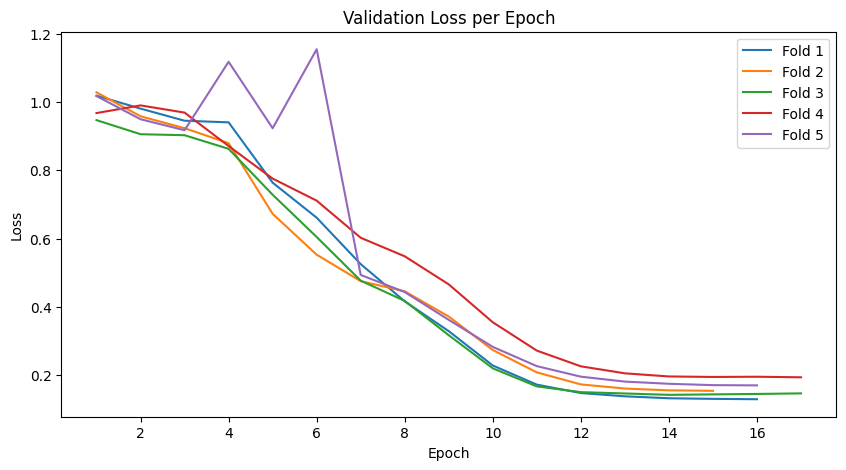

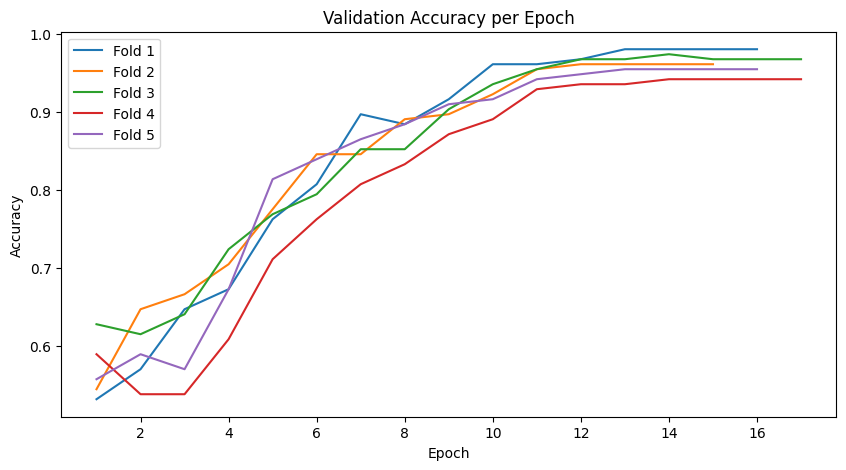

In [61]:
import matplotlib.pyplot as plt

# Plot the average loss graph
plt.figure(figsize=(10, 5))
for i, losses in enumerate(fold_val_losses):
    plt.plot(range(1, len(losses) + 1), losses, label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()
plt.show()

# Plot the average accuracy graph
plt.figure(figsize=(10, 5))
for i, accs in enumerate(fold_val_accs):
    accs_cpu = [acc.cpu().numpy() for acc in accs]
    plt.plot(range(1, len(accs_cpu) + 1), accs_cpu, label=f'Fold {i+1}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.show()

In [83]:
import numpy as np

# Extract validation accuracies from each fold
val_accuracies = [0.9808, 0.9615, 0.9744, 0.9423, 0.9551]  # Replace with actual validation accuracies

# Compute mean accuracy and standard deviation
mean_accuracy = np.mean(val_accuracies)
std_accuracy = np.std(val_accuracies)

print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation:", std_accuracy)

Mean Accuracy: 0.96282
Standard Deviation: 0.013709762944704777


# Data Prepration for Report

In [87]:
import numpy as np

conf_matrix = [[65, 0, 1],
               [1, 30, 0],
               [0, 0, 20]]

# Convert confusion matrix to numpy array for easier manipulation
conf_matrix = np.array(conf_matrix)

# Calculate true positives, false positives, false negatives for each class
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP

# Calculate true negatives for each class (excluding diagonal)
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Compute accuracy for each class
accuracy = (TP + TN) / (TP + FP + FN + TN)

# Compute precision for each class
precision = TP / (TP + FP)

# Compute recall for each class
recall = TP / (TP + FN)

# Compute F1-score for each class
f1_score = 2 * (precision * recall) / (precision + recall)

# Compute overall accuracy
overall_accuracy = np.sum(TP) / np.sum(conf_matrix)

# Calculate percentages
total = np.sum(conf_matrix)
TP_percent = (TP / total) * 100
FP_percent = (FP / total) * 100
FN_percent = (FN / total) * 100
TN_percent = (TN / total) * 100

# Calculate average values
average_accuracy = np.mean(accuracy)
average_precision = np.mean(precision)
average_recall = np.mean(recall)
average_f1_score = np.mean(f1_score)

# Print results
print("Average Accuracy:", average_accuracy)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1-score:", average_f1_score)
print("Overall Accuracy:", overall_accuracy)
print("Average TP:", np.mean(TP), "(", np.mean(TP_percent), "%)")
print("Average FP:", np.mean(FP), "(", np.mean(FP_percent), "%)")
print("Average FN:", np.mean(FN), "(", np.mean(FN_percent), "%)")
print("Average TN:", np.mean(TN), "(", np.mean(TN_percent), "%)")

Average Accuracy: 0.9886039886039887
Average Precision: 0.979076479076479
Average Recall: 0.9841968067774519
Average F1-score: 0.9813549327743649
Overall Accuracy: 0.9829059829059829
Average TP: 38.333333333333336 ( 32.76353276353276 %)
Average FP: 0.6666666666666666 ( 0.5698005698005698 %)
Average FN: 0.6666666666666666 ( 0.5698005698005698 %)
Average TN: 77.33333333333333 ( 66.0968660968661 %)


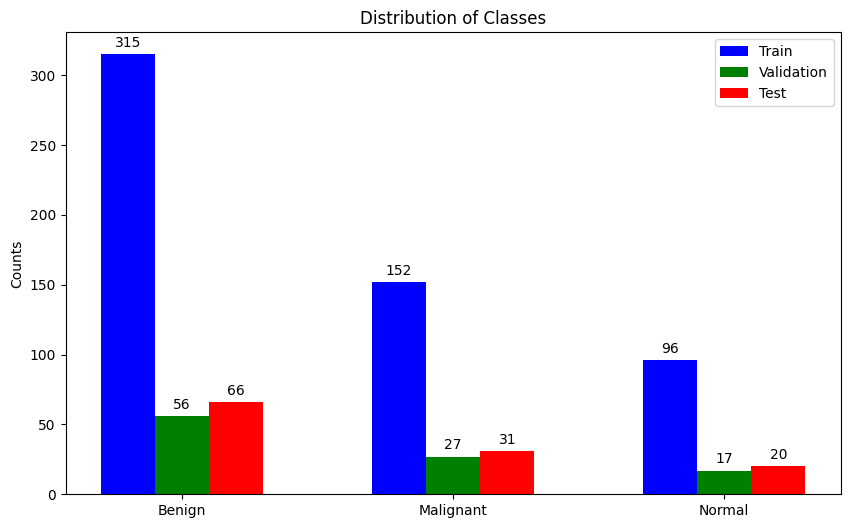

In [91]:
import matplotlib.pyplot as plt

# Define the classes and their counts
classes = ['Benign', 'Malignant', 'Normal']
train_counts = [315, 152, 96]
val_counts = [56, 27, 17]
test_counts = [66, 31, 20]

# Define the positions for the bars
x = range(len(classes))

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot train counts
bars_train = ax.bar([i - 0.2 for i in x], train_counts, width=0.2, color='b', align='center', label='Train')
# Plot validation counts
bars_val = ax.bar(x, val_counts, width=0.2, color='g', align='center', label='Validation')
# Plot test counts
bars_test = ax.bar([i + 0.2 for i in x], test_counts, width=0.2, color='r', align='center', label='Test')

# Add labels, title, and legend
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Counts')
ax.set_title('Distribution of Classes')
ax.legend()

# Add actual counts above the bars
for bars in [bars_train, bars_val, bars_test]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Show plot
plt.show()

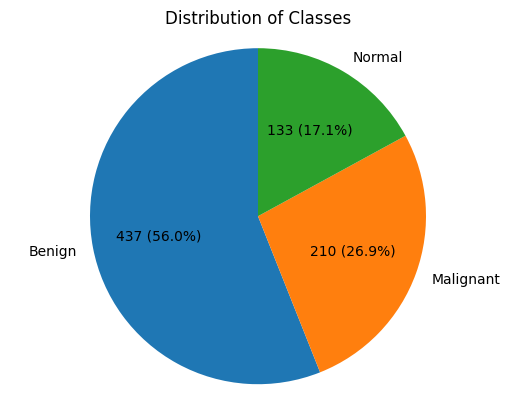

In [93]:
import matplotlib.pyplot as plt

# Define the labels and counts
labels = ['Benign', 'Malignant', 'Normal']
counts = [437, 210, 133]

# Create the pie chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')  

# Add numbers to the wedges
for i, autotext in enumerate(autotexts):
    autotext.set_text(f"{counts[i]} ({autotext.get_text()})")

# Add title
ax.set_title('Distribution of Classes')

# Show the plot
plt.show()

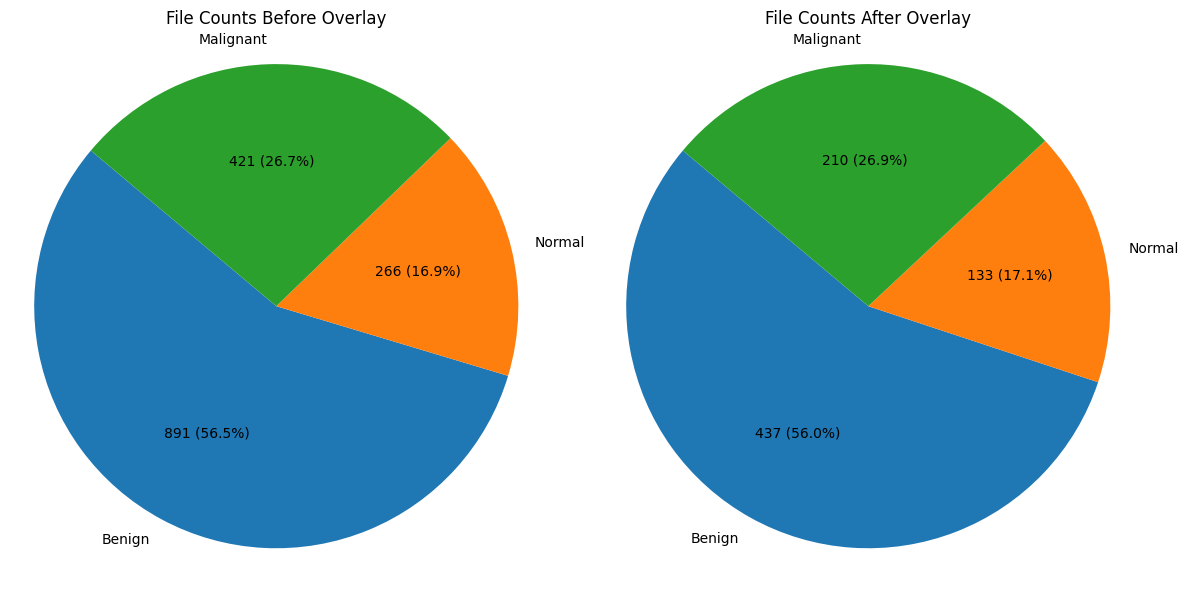

In [90]:
import matplotlib.pyplot as plt

# Define classes and their counts before and after overlay
classes = ['Benign', 'Normal', 'Malignant']
file_counts_before_overlay = [891, 266, 421]
file_counts_after_overlay = [437, 133, 210]

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot pie chart for file counts before overlay
wedges, texts, autotexts = ax[0].pie(file_counts_before_overlay, labels=classes, autopct='%1.1f%%', startangle=140)
ax[0].set_title('File Counts Before Overlay')
for i, text in enumerate(autotexts):
    text.set_text(f'{file_counts_before_overlay[i]} ({text.get_text()})')

# Plot pie chart for file counts after overlay
wedges, texts, autotexts = ax[1].pie(file_counts_after_overlay, labels=classes, autopct='%1.1f%%', startangle=140)
ax[1].set_title('File Counts After Overlay')
for i, text in enumerate(autotexts):
    text.set_text(f'{file_counts_after_overlay[i]} ({text.get_text()})')

# Equal aspect ratio ensures that pie is drawn as a circle
ax[0].axis('equal')
ax[1].axis('equal')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()